# Compress Models
In this notebook we will try to compress the Pix2Pix model by a factor of 10 and implement the following [paper](https://arxiv.org/pdf/2103.03467.pdf):
![image](https://user-images.githubusercontent.com/20357655/158659328-ecec21df-e5d7-4650-a135-61377710e752.png)

By the way, if you've seen the Cartoonify or Anime filters in Snapchat, they are made using this approach. More specifically, this approach made it possible to port to the phone and run real-time neural networks.
![image](https://avatars.mds.yandex.net/get-turbo/3759699/rth781da07d5a5bba22ef4e4a290367cdab/max_g480_c12_r16x9_pd20)

So, let's shortly enumerate main points in method:

1. We train the `Teacher Generator`. A huge network that have a good enough quality. So nextly we want somehow to distill knowledge to student. But what is the best architecture for student network? 🤔🤔🤔
2. We can simply thin `Teacher Generator` by depth or width, but it doesn't work :(.
   Let's better make a teacher so that we can `prune` it (i.e., throw out layers/channels/whatever that don't give much use to the final prediction) and take such a network as the basis for the student.
   To do that, we introduce `IncResBlock`. The `IncResBlock` includes six types of operations, with two types of convolution layers and three different kernel-sizes. Such a unit allows us to make a large and varied `search space` for our student architecture.
3. After training the `Teacher Generator` with `IncResBlock` as the main building block, we can prune our teacher and get a student.
   We prune the channels through the `magnitudes of scaling factors in normalization layers`, such as Batch Normalization (BN) and Instance Normalization (IN). For pruning we need `threshold` which we determine by a given computation budget, which can be `MACs` or latency.
4. After obtaining a student network architecture, we train it from scratch, leveraging the teacher model for knowledge distillation.
   We transfer knowledge between the two networks’ feature spaces with help of `Kernel Alignment` function.
   Its advantage is that it is invariant to the number of channels in the student and teacher trait map
   
If you have some quastions? Feel free to read paper :)

In [ ]:
from typing import Callable, Dict, Optional, Tuple

import os
import sys
import time
import tqdm
import copy
import random
import pathlib
import collections
import dataclasses
import itertools
import functools
from IPython import display
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

display.HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

# Data

## Download dataset

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1urAAXF4deL6q2lvise5NcXlbrFT1GjoF
!gdown https://drive.google.com/uc?id=1f_WOW-ihxpo1yiMq67EaHh1rOjZOpYgF

In [ ]:
!unzip val.zip -d cityscapes_dataset
!unzip train.zip -d cityscapes_dataset

## Download pretrained Teacher

In [ ]:
!gdown https://drive.google.com/uc?id=1cTMAiTEGyMiBSlKQ4oTQuI1ZlQSi4R0h
!gdown https://drive.google.com/uc?id=1b8rRTd5nlC1REdC_0C4St946I9ApgQTf

---

# Configs

In [ ]:
@dataclasses.dataclass
class DataConfig:
    dataroot: str = 'cityscapes_dataset'
    direction: str = 'BtoA'

@dataclasses.dataclass
class TrainingConfig:
    batch_size: int = 32
    num_workers: int = 8
    lr: float = 0.0002
    epoch: int = 200
    reconstruction_lambda: float = 100.0
    distillation_lambda: float = 1.0
    generator_lambda: float = 1.0

# Dataset & Dataloader

In [ ]:
from homework_utils.dataset import AlignedDataset
import albumentations

from albumentations.pytorch import ToTensorV2

In [ ]:
def normalize(image, **kwargs):
    return albumentations.functional.normalize(
        image,
        mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    )

In [ ]:
base_transform = albumentations.Compose([
    albumentations.Lambda(image=normalize, mask=normalize),
    ToTensorV2(transpose_mask=True)
])

train_transform = albumentations.Compose([
    albumentations.Resize(276, 276),
    albumentations.RandomCrop(256, 256),
    albumentations.HorizontalFlip(),
    base_transform
])
train_dataset = AlignedDataset(
    DataConfig.dataroot, transform=train_transform,
    direction=DataConfig.direction
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=TrainingConfig.batch_size,
    num_workers=TrainingConfig.num_workers,
    shuffle=True
)

validation_transform = albumentations.Compose([
    base_transform
])
validation_dataset = AlignedDataset(
    DataConfig.dataroot, is_train=False,
    transform=validation_transform,
    direction=DataConfig.direction
)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=TrainingConfig.batch_size,
    num_workers=TrainingConfig.num_workers,
)

In [ ]:
mask, image = train_dataset[0]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(mask.permute(1, 2, 0).mul(0.5).add(0.5))
axes[1].imshow(image.permute(1, 2, 0).mul(0.5).add(0.5))
for ax in axes:
    ax.axis('off')
plt.show()

---

# Models

In [ ]:
from homework_utils.models import Discriminator
from homework_utils.models import InvertedResidualChannels, InceptionGenerator

The main building block in the teacher and student generators is `InvertedResidualChannels`. Below is a schematic of the block

![image](https://user-images.githubusercontent.com/20357655/158647827-66f511fe-0471-4f2f-bfa1-2c23487013c4.png)

# Task №1 [1 point]

Implement distillation loss:
$$
\mathrm{KA}(X, Y)=\frac{\left\|Y^{\mathrm{T}} X\right\|_{\mathrm{F}}^{2}}{\left\|X^{\mathrm{T}} X\right\|_{\mathrm{F}}\left\|Y^{\mathrm{T}} Y\right\|_{\mathrm{F}}}
$$

And use it to distillate intermediate features:
We conduct distillation on the feature space. Let $\mathcal{S}_{\mathrm{KD}}$ denote the set of layers for performing knowledge distillation, whereas $X_{t}^{(l)}$ and $X_{s}^{(l)}$ denote feature tensors of layer $l$ from the teacher and student networks, respectively. We minimize the distillation loss $\mathcal{L}_{\text {dist }}$ as follows:
$$
\mathcal{L}_{\text {dist }}=-\sum_{l \in \mathcal{S}_{\mathrm{KD}}} \mathrm{KA}\left(X_{t}^{(l)}, X_{s}^{(l)}\right)
$$
where the minus sign is introduced as we intend to maximize feature similarity between student and teacher models.

In [ ]:
class KernelAlignmentLoss(nn.Module):
    pass

## Criterions

In addition to Hinge, we will use L1 to reconstruct the true images

In [ ]:
class HingeLoss(nn.Module):
    
    def __init__(self):
        super(HingeLoss, self).__init__()
        self.register_buffer('zero_tensor', torch.tensor(0.))
    
    def get_zero_tensor(self, prediction):
        return self.zero_tensor.expand_as(prediction)
    
    def forward(
        self,
        prediction: torch.Tensor,
        target_is_real: bool,
        for_discriminator: bool = True
    ):
        if for_discriminator:
            if target_is_real:
                minval = torch.min(prediction - 1, self.get_zero_tensor(prediction))
                loss = -torch.mean(minval)
            else:
                minval = torch.min(-prediction - 1, self.get_zero_tensor(prediction))
                loss = -torch.mean(minval)
        else:
            loss = -torch.mean(prediction)
        
        return loss

## Metric Calculator

We run an image segmentation model, which is DRN-D-105, on the generated images to calculate mean Intersection over Union (mIoU). A higher value of mIoU indicates better quality of generated images.

![image](https://avatars.mds.yandex.net/i?id=ddc40e9238f27ab4b2529718e2772d97-5236353-images-thumbs&n=13)

In [ ]:
from homework_utils.models import DRNSeg


class Segmentator(nn.Module):

    def __init__(self):
        super(Segmentator, self).__init__()
        self._drn_model = DRNSeg('drn_d_105', 19, pretrained=False).eval()
        self._drn_model.load_state_dict(
            torch.load('drn-d-105_ms_cityscapes.pth', 'cpu')
        )

        self.register_buffer(
            'mean', torch.tensor([0.2901009, 0.3280814, 0.2869639]).view(1, -1, 1, 1))
        self.register_buffer(
            'std', torch.tensor([0.1829540, 0.1865656, 0.1844750]).view(1, -1, 1, 1))
    
    @torch.inference_mode()
    def forward(self, image: torch.Tensor):
        normalized_image = image.sub(self.mean).div(self.std)
        return self._drn_model(normalized_image)[0].argmax(dim=1, keepdim=True)

# Training

In [ ]:
from homework_utils.metrics import fast_hist, per_class_iu

device = torch.device('cuda:0')

## Teacher Generator

In [ ]:
teacher_generator = InceptionGenerator(
    3, 3, 64, 256, 6, [1, 3, 5],
    norm_layer=nn.BatchNorm2d
).eval().to(device)
teacher_checkpoint = torch.load('best_net_G.pth', 'cpu')
teacher_generator.load_state_dict(teacher_checkpoint)

### Let's make sure that the generator really works

In [ ]:
random_index = random.randint(0, len(validation_dataset) - 1)
mask, image = validation_dataset[random_index]
with torch.inference_mode():
    fake_image = teacher_generator(mask[None].to(device))
    fake_image = fake_image.cpu()[0]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image.mul(0.5).add(0.5).permute(1, 2, 0))
axes[1].imshow(fake_image.mul(0.5).add(0.5).permute(1, 2, 0))
plt.show()

# Task №2 [2 points]

In order to distill a teacher into a student, we need to be able to extract intermediate features from the network.
To do this, you should use a recent feature in pytorch: [torch.fx](https://pytorch.org/docs/stable/fx.html)

Or you can use the old-fashioned [forward-hooks](https://pytorch.org/docs/stable/notes/modules.html#module-hooks), but the number of points will be halved

In [ ]:
# The output feature maps of these modules in the teacher/student model should be obtained
layers = ('down_sampling.9', 'features.2', 'features.5', 'features.8')

# Task №3 [2 points]

The teacher model can be viewed as a large search space that enables one-shot neural architecture search without training an extra supernet. We will prune the channels (of teacher generator) through the magnitudes of scaling factors in normalization layers, such as
Batch Normalization (BN). To this end, a threshold is required to choose channels to prune.

To solve this, we determine the threshold by a given computation budget, which can be MACs or latency.
So first, we have to learn how to count the number of MACs for our generator to know if we can increase or decrease the threshold in pruning

In [ ]:
class ModuleProfiler:
    
    def __init__(
        self,
        module: nn.Module,
        height: int,
        width: int,
        batch: int = 1,
        channel: int = 3,
        device = torch.device('cpu'),
    ):
        self._module = module.eval().to(device)
        self._data = torch.randn(batch, channel, height, width, device=device)
        
        self._hooks = []
    
    @staticmethod
    def get_num_params(module: nn.Module):
        return sum([p.numel() for p in module.parameters()])
    
    @staticmethod
    def profiling_hook(
        module: nn.Module,
        inputs: Tuple[torch.Tensor, ...],
        output: torch.Tensor
    ):
        input_shape = inputs[0].shape
        output_shape = output.shape

        if isinstance(module, nn.Conv2d):
            module.num_macs = (
                input_shape[1] * output_shape[1] * 
                module.kernel_size[0] * module.kernel_size[1] *
                output_shape[2] * output_shape[3] // module.groups) \
                * output_shape[0]
            module.num_params = ModuleProfiler.get_num_params(module)
            module.num_seconds = 0
            
        # TODO add all required modules to be able to count MACs in InceptionGenerator
        
        else:
            module.num_macs = 0
            module.num_params = 0
            module.num_seconds = 0

            for m in module.children():
                module.num_macs += getattr(m, 'num_macs', 0)
                module.num_params += getattr(m, 'num_params', 0)
                module.num_seconds += getattr(m, 'num_seconds', 0)
    
    def __call__(self):
        def add_profiling_hook(module: nn.Module):
            self._hooks.append(module.register_forward_hook(self.profiling_hook))
        
        self._module.apply(add_profiling_hook)
        with torch.inference_mode():
            _ = self._module(self._data)
        
        for hook in self._hooks:
            hook.remove()
        
        return self._module.num_macs, self._module.num_params

In [ ]:
dummy_model = nn.Sequential(nn.Conv2d(3, 3, 3), nn.ReLU(), nn.Conv2d(3, 3, 3))
profiler = ModuleProfiler(dummy_model, 256, 256)
num_macs, num_params = profiler()
print(num_macs)

In [ ]:
test_model_v1 = nn.Sequential(
    nn.Conv2d(3, 16, 3, stride=1, padding=1, groups=1),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3),
    nn.Conv2d(16, 56, 5, stride=2, padding=3, groups=4, bias=False),
    nn.BatchNorm2d(56),
    nn.MaxPool2d(2),
    nn.SiLU(),
    nn.Conv2d(56, 128, 5, stride=3, padding=0, groups=2, bias=False),
    nn.InstanceNorm2d(128),
    nn.ConvTranspose2d(128, 64, 15, stride=2, padding=10),
    nn.Softmax(dim=1)
)

In [ ]:
profiler = ModuleProfiler(test_model_v1, 256, 256)
num_macs, num_params = profiler()
assert num_macs == 2_164_637_152
assert num_params == 1_938_912

In [ ]:
from homework_utils.models import ConvBNReLU, InvertedResidualChannels

test_model_v2 = nn.Sequential(
    ConvBNReLU(3, 64, kernel_size=3, stride=2, groups=1, active_fn=nn.ReLU),
    ConvBNReLU(64, 128, kernel_size=5, groups=4, active_fn=nn.ReLU),
    InvertedResidualChannels(
        128, 256, 256, 6,
        [1, 3, 5], [1, 3, 5],
        norm_layer=nn.BatchNorm2d,
        active_fn=nn.ReLU
    ),
    InvertedResidualChannels(
        128, [32, 32, 192], [64, 64, 128], 6,
        [1, 3, 5], [1, 3, 5],
        norm_layer=nn.InstanceNorm2d,
        active_fn=nn.ReLU
    )
)

In [ ]:
profiler = ModuleProfiler(test_model_v2, 256, 256)
num_macs, num_params = profiler()
assert num_macs == 10_473_162_931
assert num_params == 693_925

In [ ]:
profiler = ModuleProfiler(teacher_generator, 256, 256)
teacher_num_macs, teacher_num_params = profiler()
assert teacher_num_macs == 43_490_402_304
assert teacher_num_params == 8_123_697

# Task №4 [2 points]

Now we can use a binary search to find the threshold that will give us the desired number of MACs

![image](https://user-images.githubusercontent.com/20357655/158655882-764c903b-9338-4141-9606-f3bb152f0d24.png)

In [ ]:
cumputational_budget = teacher_num_macs // 10

In [ ]:
def teacher_pruning(teacher, cumputational_budget, channel_lower_bound=16) -> nn.Module:
    student = copy.deepcopy(teacher)
    return student

In [ ]:
student_generator = teacher_pruning(teacher_generator, cumputational_budget)

# And don't forget to do Task №2 for `student_generator`

## Critic, criterions and optimizers

In [ ]:
critic = Discriminator(6, use_affine=False).to(device)
segmentator = Segmentator().to(device)

gan_criterion = HingeLoss().to(device)
reconstruction_criterion = nn.L1Loss()
distillation_criterion = KernelAlignmentLoss()

critic_optimizer = torch.optim.Adam(
    critic.parameters(), lr=TrainingConfig.lr,
    betas=(0.5, 0.999)
)
generator_optimizer = torch.optim.Adam(
    student_generator.parameters(), lr=TrainingConfig.lr,
    betas=(0.5, 0.999)
)

# Task №5 [3 points]

Finally, we are ready to start to train something :)

The overall loss function for student training is:
$$
\mathcal{L}_{\text{Student}}=\lambda_{\mathrm{adv}} \mathcal{L}_{\mathrm{adv}}+\lambda_{\text {recon }} \mathcal{L}_{\text {recon }}+\lambda_{\text {dist }} \mathcal{L}_{\text {dist }}
$$

If you implement it correctly, you should train the model in 2-3 hours (200 epochs) and get segmentation quality of ~25 m(ean)IoU.

Keep in mind that this is a toy experiment. To get something worthwhile, you need to train on 4 GPUs for about 1500 epochs with learning rate scheduler.

In [ ]:
history = collections.defaultdict(list)

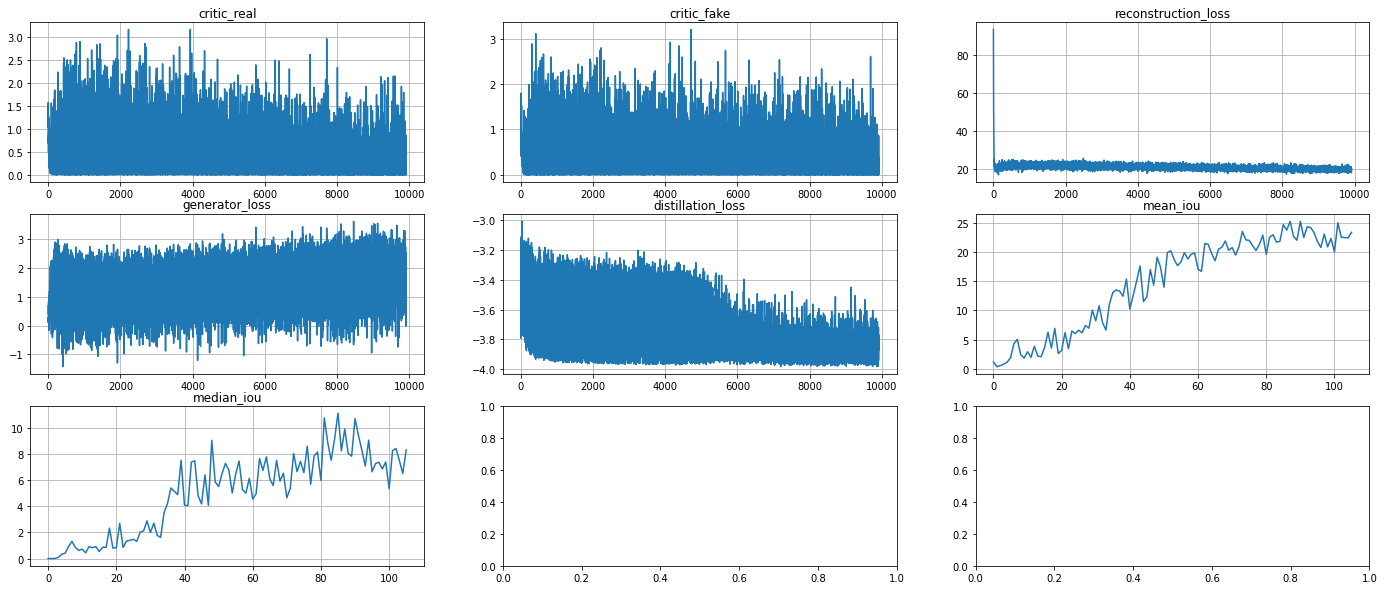

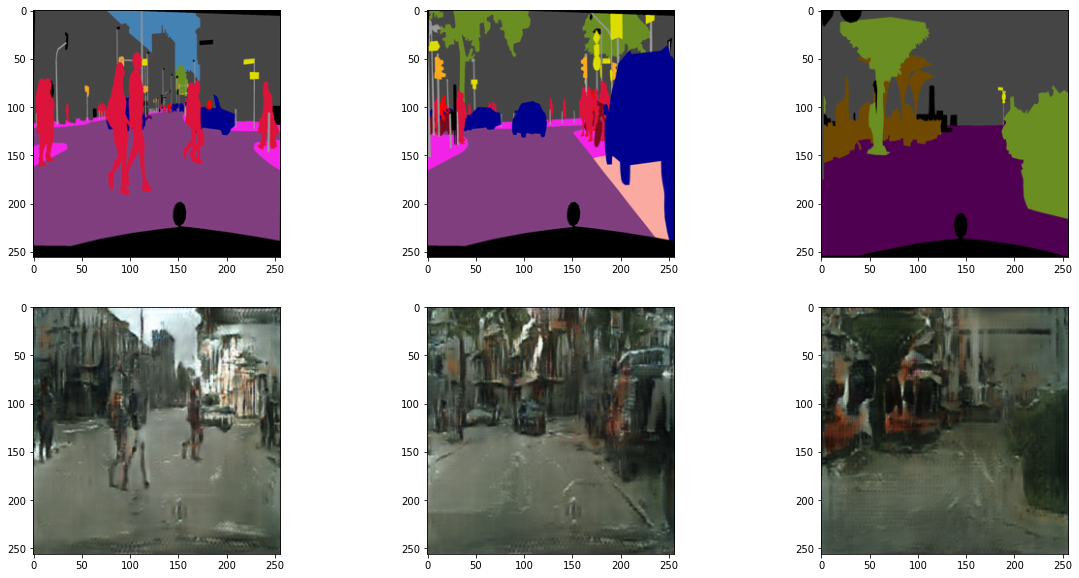

In [28]:
for epoch in range(TrainingConfig.epoch):
    
    student_generator.train()
    for _, batch in enumerate(tqdm.tqdm(train_dataloader)):
        segmentation_mask, image = batch
        segmentation_mask = segmentation_mask.to(device)
        image = image.to(device)
        
        # TODO
        teacher_fake_image = ...
        student_fake_image = ...
        
        ###################################
        ###### Update Student Critic ######
        ###################################
        
        # TODO
        critic_response_on_real = ...
        critic_respose_on_fake = ...
        total_critic_loss = 0.5 * (critic_response_on_real + critic_respose_on_fake)

        
        ###################################
        ##### Update Student Generator ####
        ###################################

        reconstruction_loss = ...
        generator_loss = ...
        distillation_loss = ...

        total_generator_loss = reconstruction_loss + generator_loss + distillation_loss
        
        ###################################
        ############# Logging #############
        ###################################
        losses = {
            'critic_real': critic_response_on_real.item(),
            'critic_fake': critic_respose_on_fake.item(),
            'reconstruction_loss': reconstruction_loss.item(),
            'generator_loss': generator_loss.item(),
            'distillation_loss': distillation_loss.item()
        }
        for k, v in losses.items():
            history[k].append(v)
            
    
    ###################################
    ############ Evaluation ###########
    ###################################
    num_classes = 19
    hist = np.zeros((num_classes, num_classes))
    student_generator.eval()
    for batch in tqdm.tqdm(validation_dataloader):
        segmentation_mask, image = batch
        segmentation_mask = segmentation_mask.to(device)
        image = image.to(device)
    
        with torch.inference_mode():
            fake_image = student_generator(segmentation_mask)
    
        # Denormalize
        image = image.mul(.5).add(0.5)
        fake_image = fake_image.mul(.5).add(0.5)
        
        predicted_segmentation_mask = segmentator(image).cpu()
        predicted_fake_segmentation_mask = segmentator(fake_image).cpu()
        
        hist += fast_hist(
            predicted_fake_segmentation_mask.numpy().flatten(),
            predicted_segmentation_mask.numpy().flatten(),
            num_classes
        )
    
    mean_iou = np.nanmean(per_class_iu(hist) * 100)
    median_iou = np.nanmedian(per_class_iu(hist) * 100)
    history['mean_iou'].append(mean_iou)
    history['median_iou'].append(median_iou)
    
    ###################################
    ############ Visualise ############
    ###################################
    display.clear_output()
    fig, axes = plt.subplots(3, 3, figsize=(24, 10))
    axes = axes.flatten()
    for ax, (k, v) in zip(axes, history.items()):
        ax.plot(v)
        ax.grid()
        ax.set_title(k)
    plt.show()

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    for i, (mask, image) in enumerate(zip(
        segmentation_mask.cpu()[::5][:3],
        fake_image[::5][:3].cpu()
    )):
        axes[i].imshow(mask.permute(1, 2, 0).mul(0.5).add(0.5))
        axes[i + 3].imshow(image.permute(1, 2, 0))
    plt.show()

# Bonus [up to 2 point]
Try to speed up training loop :)

For example, you can try:
* Speed up augmentation.
* Cache the dataset
* Load images directly to the GPU
* And so on... Be creative

---

Well, here you can cry about how hard it was or leave memes (bonuses for good memes, too)